# Modelling

The main objectives for this notebook are:
* To develop a model that will satisfiy our modelling objective
* To properly evaluate the developed model
* To have a trained model ready for deployment


## good things to do
1. Have a proper baseline
2. Perform post-modellign steps - threshold selection, explainability, false positives / false negatives
3. Use MLFlow for experiment tracking
4. Build an ML training pipeline using Kedro/ZenML/Metaflow/etc


In [1]:
import os
import sys
import warnings

import joblib
import mlflow
import numpy as np
import plotly.express as px
import polars as pl
import shap
from optuna.integration.mlflow import MLflowCallback
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split

c:\Users\larib\Projects\Api security\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Path needs to be added manually to read from another folder
path2add = os.path.normpath(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), os.path.pardir, "utils"))
)
if  (path2add not in sys.path):
    sys.path.append(path2add)

from ml_util_funcs import evaluate_thresholds, tune_hgbt

In [4]:
warnings.filterwarnings("ignore")
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("api_anomaly")
mlflow.sklearn.autolog(disable=True)

2024/11/05 09:55:02 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/11/05 09:55:02 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

## Read Data

In [6]:
data = pl.read_parquet('../data/supervised_clean_data_w_features.parquet')
data.sample(3)

,_id,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,num_sessions,num_users,num_unique_apis,source,classification,is_anomaly,max_global_source_degrees,avg_global_source_degrees,min_global_dest_degrees,std_local_source_degrees,max_global_dest_degrees,min_global_source_degrees,std_global_source_degrees,n_connections,avg_global_dest_degrees
i64,str,f64,f64,f64,i64,str,f64,f64,f64,str,str,bool,u32,f64,u32,f64,u32,u32,f64,u32,f64
1206,"""bf53ab82-2b4e-3820-8818-6c7f02…",0.60275,0.5,6.0,217,"""default""",2.0,1.0,3.0,"""E""","""outlier""",true,32071,32071.0,1217,null,1217,32071,null,1,1217.0
341,"""d9d846e3-b048-3388-80c8-a361c3…",0.000009,0.017857,8.823151,4,"""default""",1947.0,622.0,98.0,"""E""","""normal""",false,32071,6817.737037,23,6.879318,22416,21,8789.635104,270,8213.018519
729,"""f1dce7b4-d28d-3d8b-9d01-7ef372…",0.00544,0.018262,26.737089,1859,"""default""",296.0,213.0,104.0,"""E""","""normal""",false,32071,6428.850794,26,7.899586,22416,15,8838.839606,315,7639.907937


## Data Processing for Modelling

Doing initial modelling, I've noticed that we can perfectly prdict outliers using the provided features which is not surprising - it's generally quite easy to replicate the results of unsupervised models in a supervised way. Hence, the modelling goal for this project has shifted from <br><br> `To develop a supervised model to classify behaviour into normal and anomalous` <br><br> to <br><br>`To develop a supervised model using the engineered features to classify behaviour into normal and anomalous` 

In [7]:
label = "is_anomaly"
numerical_features = [
    "max_global_source_degrees",
    "avg_global_source_degrees",
    "min_global_dest_degrees",
    "std_local_source_degrees",
    "max_global_dest_degrees",
    "min_global_source_degrees",
    "std_global_source_degrees",
    "n_connections",
    "avg_global_dest_degrees",
]

data = data.filter(pl.col('ip_type') == 'default').select([label] + numerical_features) # 
data.sample(3)

is_anomaly,max_global_source_degrees,avg_global_source_degrees,min_global_dest_degrees,std_local_source_degrees,max_global_dest_degrees,min_global_source_degrees,std_global_source_degrees,n_connections,avg_global_dest_degrees
bool,u32,f64,u32,f64,u32,u32,f64,u32,f64
false,32071,5920.831579,3,7.225176,22416,3,8100.117708,380,7046.963158
false,32071,9067.145455,580,2.325094,22416,476,10049.337307,55,8816.490909
false,32071,6867.384615,813,2.277397,22416,403,9907.997773,65,6246.953846


In [8]:
X_train, X_test, y_train, y_test = train_test_split(data[numerical_features], data[label].to_list(), test_size=0.2)

In [9]:
print("Train shape: ", X_train.shape)
print("Test shape::", X_test.shape)

Train shape:  (1233, 9)
Test shape:: (309, 9)


## Baseline
Before building a model, we need to understand whether the problem can be solved without using ML. 

In [10]:
from sklearn.metrics import f1_score

heuristic_f1_scores = []
possible_values = X_train['n_connections'].sort().unique().to_list()
for v in possible_values:
    heuristic_pred = X_test.select(pl.col('n_connections') <= v).to_pandas()
    heuristic_f1_scores.append(f1_score(y_test, heuristic_pred))

In [11]:
px.line(
    x=possible_values, 
    y=heuristic_f1_scores, 
    labels={
        "x": "Number of Connections Threshold",
        "y": "F1 Score",
    },
    title='F1 Score for Heuristic Rule'
)

**Insights**
* The optimal number of connections to set as threshold is 46
* Heuristic rule can achive the F1 score of 0.73

## Machine Learning

### Base Model

In [14]:
with mlflow.start_run(run_name='GBT_baseline'):
    params = {
        "learning_rate": 0.1,
        "max_iter": 100,
        "max_leaf_nodes": 31,
        "max_depth": None,
        "l2_regularization": 0,
    }

    mlflow.set_tag("model_name", "HGBT")
    mlflow.log_params(params)

    gbt = HistGradientBoostingClassifier(**params)
    
    roc_auc = cross_val_score(gbt, X_train, y_train, cv=5, scoring='roc_auc').mean()
    print('ROC AUC (avg 5-fold):', roc_auc)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.sklearn.log_model(gbt, "gbt_models")

ROC AUC (avg 5-fold): 0.9894815494223483


2024/11/05 10:19:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


**Observations**
* The ROC AUC achieved by the baseline model has very high ROC AUC score of 0.99

**Insights**
* This indicates either target leakage or that the task is very simple
* Given that we don't know how the target was created, we can assume that the data set creates have used some simple anomaly detection methods

**Impact**
* We don't need to do hyperparameter tuning because the task is too simple

### Tuned Model

In [15]:
mlflc = MLflowCallback(
    tracking_uri="sqlite:///mlflow.db",
    metric_name="roc auc",
)

best_trial = tune_hgbt(20, mlflc, X_train, y_train)

[I 2024-11-05 10:21:55,399] A new study created in memory with name: hgbt_tuning
2024/11/05 10:21:55 INFO mlflow.tracking.fluent: Experiment with name 'hgbt_tuning' does not exist. Creating a new experiment.
[I 2024-11-05 10:21:55,524] Trial 0 finished with value: 0.9348906306456544 and parameters: {'max_iter': 27, 'max_leaf_nodes': 23, 'max_depth': 2, 'l2_regularization': 5.161929335764023}. Best is trial 0 with value: 0.9348906306456544.
[I 2024-11-05 10:21:55,685] Trial 1 finished with value: 0.9724612968676173 and parameters: {'max_iter': 14, 'max_leaf_nodes': 19, 'max_depth': 10, 'l2_regularization': 6.714193358698097}. Best is trial 1 with value: 0.9724612968676173.


ROC AUC (avg 5-fold): 0.9348906306456544
ROC AUC (avg 5-fold): 0.9724612968676173


[I 2024-11-05 10:21:55,885] Trial 2 finished with value: 0.965857027710609 and parameters: {'max_iter': 65, 'max_leaf_nodes': 26, 'max_depth': 2, 'l2_regularization': 1.7744548625402978}. Best is trial 1 with value: 0.9724612968676173.


ROC AUC (avg 5-fold): 0.965857027710609


[I 2024-11-05 10:21:56,215] Trial 3 finished with value: 0.9876180549765141 and parameters: {'max_iter': 56, 'max_leaf_nodes': 21, 'max_depth': 5, 'l2_regularization': 2.335204744520274}. Best is trial 3 with value: 0.9876180549765141.


ROC AUC (avg 5-fold): 0.9876180549765141


[I 2024-11-05 10:21:56,634] Trial 4 finished with value: 0.9881900089867237 and parameters: {'max_iter': 62, 'max_leaf_nodes': 13, 'max_depth': 6, 'l2_regularization': 1.833462047666774}. Best is trial 4 with value: 0.9881900089867237.


ROC AUC (avg 5-fold): 0.9881900089867237


[I 2024-11-05 10:21:56,976] Trial 5 finished with value: 0.9880320927948709 and parameters: {'max_iter': 52, 'max_leaf_nodes': 25, 'max_depth': 6, 'l2_regularization': 1.645286690301797}. Best is trial 4 with value: 0.9881900089867237.


ROC AUC (avg 5-fold): 0.9880320927948709


[I 2024-11-05 10:21:57,688] Trial 6 finished with value: 0.9881584164836894 and parameters: {'max_iter': 90, 'max_leaf_nodes': 22, 'max_depth': 10, 'l2_regularization': 5.587468722255652}. Best is trial 4 with value: 0.9881900089867237.


ROC AUC (avg 5-fold): 0.9881584164836894


[I 2024-11-05 10:21:58,449] Trial 7 finished with value: 0.9890827982990078 and parameters: {'max_iter': 92, 'max_leaf_nodes': 28, 'max_depth': 10, 'l2_regularization': 2.2145420376780445}. Best is trial 7 with value: 0.9890827982990078.


ROC AUC (avg 5-fold): 0.9890827982990078


[I 2024-11-05 10:21:59,272] Trial 8 finished with value: 0.9881997832068707 and parameters: {'max_iter': 93, 'max_leaf_nodes': 17, 'max_depth': 10, 'l2_regularization': 5.879539609591289}. Best is trial 7 with value: 0.9890827982990078.
[I 2024-11-05 10:21:59,423] Trial 9 finished with value: 0.9494387466763019 and parameters: {'max_iter': 41, 'max_leaf_nodes': 21, 'max_depth': 2, 'l2_regularization': 3.033913981377961}. Best is trial 7 with value: 0.9890827982990078.


ROC AUC (avg 5-fold): 0.9881997832068707
ROC AUC (avg 5-fold): 0.9494387466763019


[I 2024-11-05 10:22:00,009] Trial 10 finished with value: 0.9863521313358719 and parameters: {'max_iter': 78, 'max_leaf_nodes': 31, 'max_depth': 8, 'l2_regularization': 8.9855515497306}. Best is trial 7 with value: 0.9890827982990078.


ROC AUC (avg 5-fold): 0.9863521313358719


[I 2024-11-05 10:22:00,667] Trial 11 finished with value: 0.9876326004984388 and parameters: {'max_iter': 98, 'max_leaf_nodes': 16, 'max_depth': 8, 'l2_regularization': 7.621858680272385}. Best is trial 7 with value: 0.9890827982990078.


ROC AUC (avg 5-fold): 0.9876326004984388


[I 2024-11-05 10:22:01,247] Trial 12 finished with value: 0.988675199421885 and parameters: {'max_iter': 83, 'max_leaf_nodes': 31, 'max_depth': 8, 'l2_regularization': 3.9074455533987913}. Best is trial 7 with value: 0.9890827982990078.


ROC AUC (avg 5-fold): 0.988675199421885


[I 2024-11-05 10:22:01,964] Trial 13 finished with value: 0.989241455663952 and parameters: {'max_iter': 81, 'max_leaf_nodes': 31, 'max_depth': 8, 'l2_regularization': 4.091303991123772}. Best is trial 13 with value: 0.989241455663952.


ROC AUC (avg 5-fold): 0.989241455663952


[I 2024-11-05 10:22:02,904] Trial 14 finished with value: 0.9890663998443537 and parameters: {'max_iter': 76, 'max_leaf_nodes': 28, 'max_depth': 9, 'l2_regularization': 0.3350615670409871}. Best is trial 13 with value: 0.989241455663952.


ROC AUC (avg 5-fold): 0.9890663998443537


[I 2024-11-05 10:22:03,814] Trial 15 finished with value: 0.9885668491805404 and parameters: {'max_iter': 73, 'max_leaf_nodes': 28, 'max_depth': 7, 'l2_regularization': 3.698971660564091}. Best is trial 13 with value: 0.989241455663952.


ROC AUC (avg 5-fold): 0.9885668491805404


[I 2024-11-05 10:22:04,610] Trial 16 finished with value: 0.9881176982869636 and parameters: {'max_iter': 98, 'max_leaf_nodes': 29, 'max_depth': 9, 'l2_regularization': 0.02929431035717922}. Best is trial 13 with value: 0.989241455663952.


ROC AUC (avg 5-fold): 0.9881176982869636


[I 2024-11-05 10:22:04,974] Trial 17 finished with value: 0.9861862938566015 and parameters: {'max_iter': 85, 'max_leaf_nodes': 10, 'max_depth': 4, 'l2_regularization': 3.985915786319001}. Best is trial 13 with value: 0.989241455663952.


ROC AUC (avg 5-fold): 0.9861862938566015


[I 2024-11-05 10:22:05,386] Trial 18 finished with value: 0.9866459601434169 and parameters: {'max_iter': 45, 'max_leaf_nodes': 25, 'max_depth': 9, 'l2_regularization': 4.620261003302733}. Best is trial 13 with value: 0.989241455663952.


ROC AUC (avg 5-fold): 0.9866459601434169


[I 2024-11-05 10:22:06,127] Trial 19 finished with value: 0.9887337984194484 and parameters: {'max_iter': 69, 'max_leaf_nodes': 31, 'max_depth': 7, 'l2_regularization': 0.8437367129231474}. Best is trial 13 with value: 0.989241455663952.


ROC AUC (avg 5-fold): 0.9887337984194484


In [16]:
print(best_trial.params)

{'max_iter': 81, 'max_leaf_nodes': 31, 'max_depth': 8, 'l2_regularization': 4.091303991123772}


### The Final Model

In [18]:
best_gbt = HistGradientBoostingClassifier(**best_trial.params)
best_gbt.fit(X_train, y_train)
test_preds = best_gbt.predict_proba(X_test)

print('Test ROC AUC:', roc_auc_score(y_test, test_preds[:, 1]))
print('Test PR AUC:', average_precision_score(y_test, test_preds[:, 1]))

Test ROC AUC: 0.9872905559786748
Test PR AUC: 0.9746077060256646


## Threshold Analysis & Evaluation

In [19]:
thresholds = np.arange(0, 1.01, 0.01)

rcs, prs, f1s = evaluate_thresholds(thresholds, y_test, test_preds, plot=True)

Threshold with Max F1 Score:  0.24
F1 at threshold 0.24: 0.9230769230769231
Recall at threshold 0.24: 0.9504950495049505
Precision at threshold 0.24: 0.897196261682243 


## Model Diagnostics

#### Feature Importances

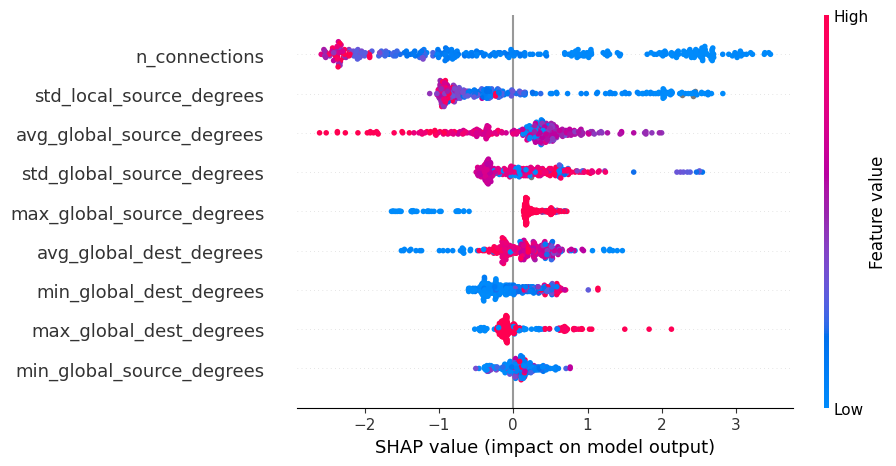

In [20]:
explainer = shap.Explainer(best_gbt)
shap_values = explainer(X_test[numerical_features].to_pandas())
shap.plots.beeswarm(shap_values)

#### False Positives & False Negatives

In [21]:
thr = 0.24
test_binary_pred = test_preds[:, 1] >= thr

fps = np.where((np.array(y_test) == False) & (test_binary_pred == True))[0]
fns = np.where((np.array(y_test) == True) & (test_binary_pred == False))[0]

print(f"There are {len(fps)} false positives")
print(f"There are {len(fns)} false negatives")

There are 11 false positives
There are 5 false negatives


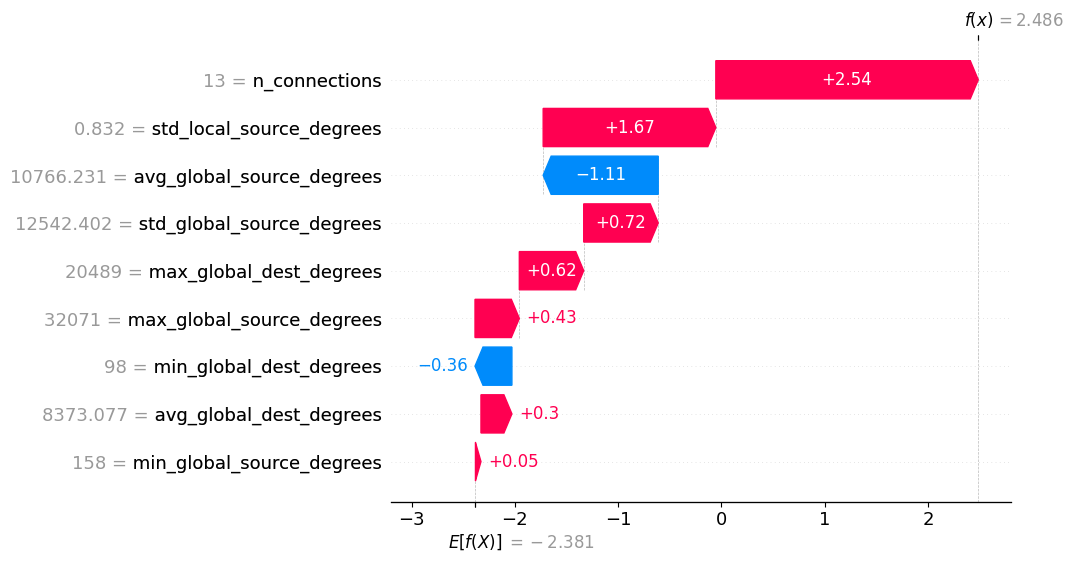

In [22]:
shap.plots.waterfall(shap_values[fps[0]])

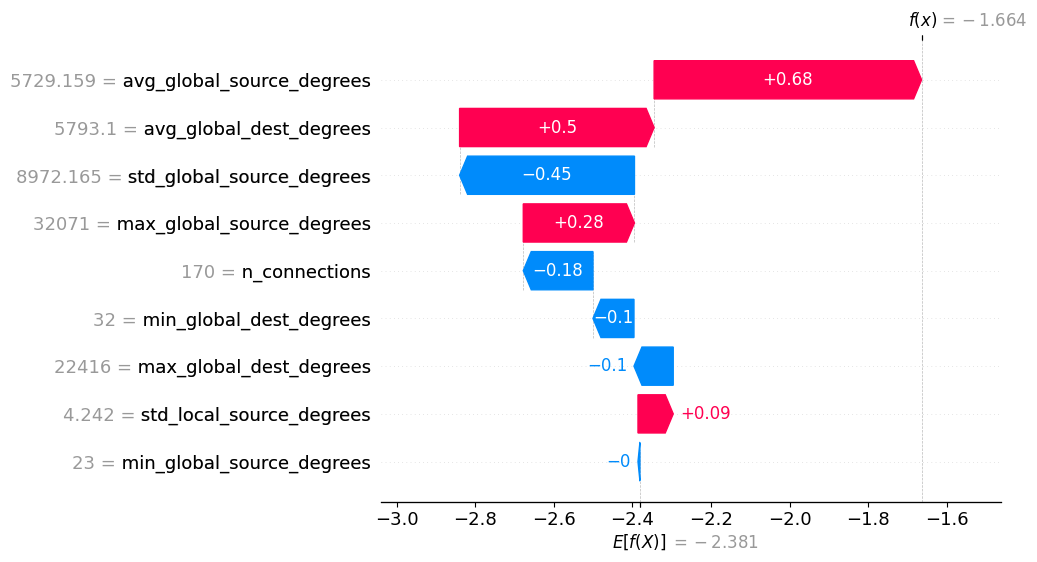

In [23]:
shap.plots.waterfall(shap_values[fns[0]])

## Save Model for Deployment

In [24]:
joblib.dump(best_gbt, '../models/hgbt_final.joblib')

['../models/hgbt_final.joblib']

## Summary

* The modelling task for anomaly detection is quite easily solved by training supervised ML model
* To make the task more challenging, only the engineered features were used to identify the anomalies
* The optimal model that was trained is HistGBT with threshold of 0.24
* The maximum F1 that can be achieved with the trained model is 0.92, which gives us a recall of 0.95 and precision 0.90
* The trained model outperforms heuristic baseline by 0.20 in terms of F1 score
* SHAP values suggest that smaller networks tend to be more anomalous